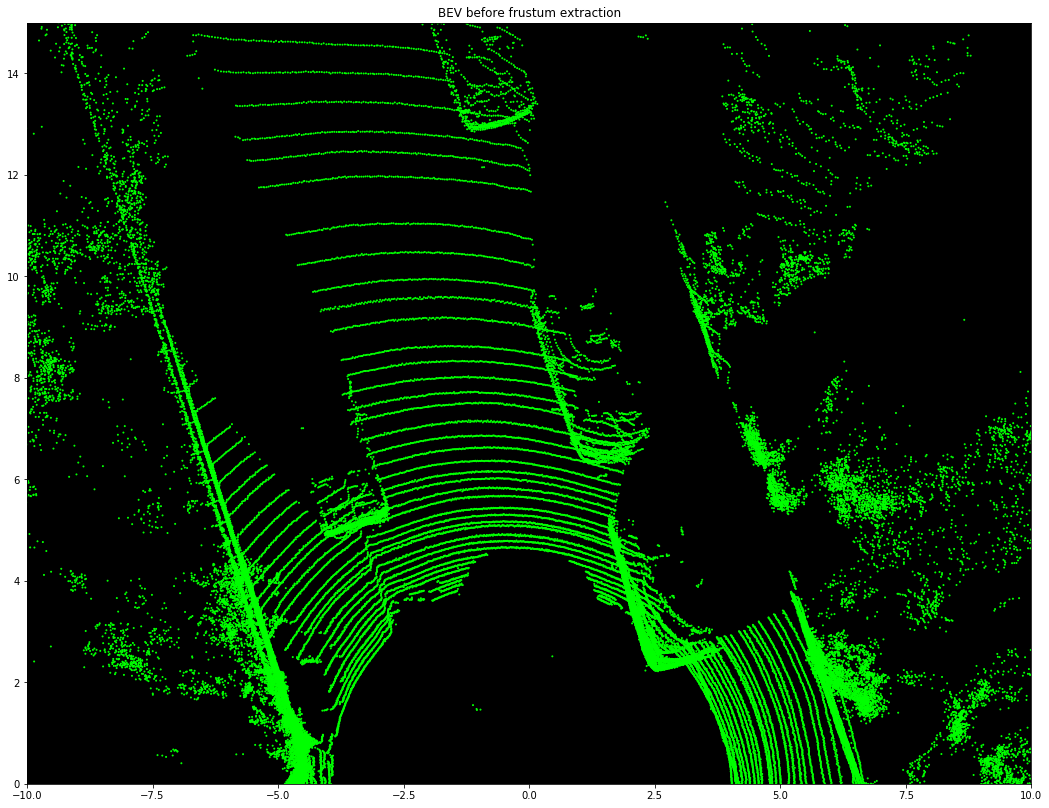

122555


In [13]:

from models import *
from utils.utils import *
from utils.datasets import *
from utils.kittiloader import *


import os
import sys
import time
import datetime
import argparse
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator
import time

from mpl_toolkits.mplot3d import Axes3D


def drawBEV(point_cloud_,color=(0,1,0)):
    f = plt.figure(figsize=(18, 14))
    ax = f.add_subplot(111)
    ax.scatter(point_cloud_[:,1],point_cloud_[:,0],
                s=1, c=[color]*len(point_cloud))
    ax.set_title('BEV before frustum extraction')
    ax.set_ylim(0,15)
    ax.set_xlim(-10,10)
    ax.set_facecolor((0,0,0))
    plt.show()
    
def draw3D(point_cloud_,color=(0,1,0),angle=(60,180)):
    f = plt.figure(figsize=(15, 10))
    ax = f.add_subplot(111, projection='3d')
    ax.set_facecolor((0, 0, 0))
    ax.set_xlim3d(-10,20)
    ax.set_ylim3d(-10,10)
    ax.set_zlim3d(-3,5)
    ax.view_init(angle[0],angle[1])
    ax.grid(False)
    plt.axis('off')
    ax.scatter(point_cloud_[:,0],point_cloud_[:,1],point_cloud_[:,2], s=1, c=[(0,1,0)]*len(point_cloud_))
    plt.show()

axes_limits = [
    [0, 10], # X axis range
    [-10, 10], # Y axis range
    [-3, 10]   # Z axis range
]
axes_str = ['X', 'Y', 'Z']


image_folder = 'examples/'
config_path = 'config/v390.cfg'
weights_path = 'weights/v390_final.weights'
kitti_path = '/home/project/ZijieMA/KITTI/'
class_path = 'data/coco.names'
conf_thres = 0.8
nms_thres = 0.4
batch_size = 1
n_cpu = 16
img_size = 416
use_cuda = True
CUDA_available = torch.cuda.is_available() and use_cuda

detections = torch.tensor([
    [  5.0433, 208.0689, 133.5634, 274.0513,   0.9992,   0.9995,   2.0000],
         [202.3678, 203.0705, 242.1279, 233.4327,   0.9980,   0.9999,   2.0000],
         [118.8502, 203.6419, 208.2199, 263.8680,   0.9891,   0.9758,   2.0000]
#          ,[271.3281, 201.2100, 280.0563, 207.2144,   0.9638,   0.9832,   2.0000],
#          [314.0755, 218.4319, 416.3620, 269.0359,   0.9204,   0.9999,   2.0000],
#          [293.7480, 207.2141, 319.6446, 226.7405,   0.8638,   0.9870,   2.0000],
#          [248.1488, 202.3865, 267.4640, 215.2374,   0.8588,   0.9984,   2.0000]
])
if detections[0] is not None:
        detections_with_distance = torch.zeros((detections.shape[0],detections.shape[1]+1))
        detections_with_distance[:,:-1] = detections
        
img_id = 8
img_path = 'examples/000008.png'
img_size_after_resize = img_size
lidar_path = '%straining/velodyne/%06d.bin' % (kitti_path, img_id)
calib = calibread('%straining/calib/%06d.txt' % (kitti_path, img_id))
img = cv2.imread('/home/project/ZijieMA/PyTorch-YOLOv3/examples/%06d.png' % img_id, cv2.IMREAD_UNCHANGED)
# img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
img_width_orig = img.shape[1]

img_height_orig = img.shape[0]

pad_x = max(img_height_orig - img_width_orig, 0) * (img_size_after_resize / max(img_width_orig, img_height_orig))
pad_y = max(img_width_orig - img_height_orig, 0) * (img_size_after_resize / max(img_width_orig, img_height_orig))
point_cloud = np.fromfile(lidar_path, dtype=np.float32).reshape(-1, 4)

# Image height and width after padding is removed
unpad_h = img_size_after_resize - pad_y
unpad_w = img_size_after_resize - pad_x
# detections with shape: (x1, y1, x2, y2, object_conf, class_score, class_pred)

P2 = calib["P2"] # 3x4 matris projection matrix after rectification
# （u,v,1） = dot(P2, (x,y,z,1))
Height_of_camera = 1.65
fu = P2[0][0]  # for horizontal position
fv = P2[1][1]  

drawBEV(point_cloud,(0,1,0))
print(len(point_cloud))

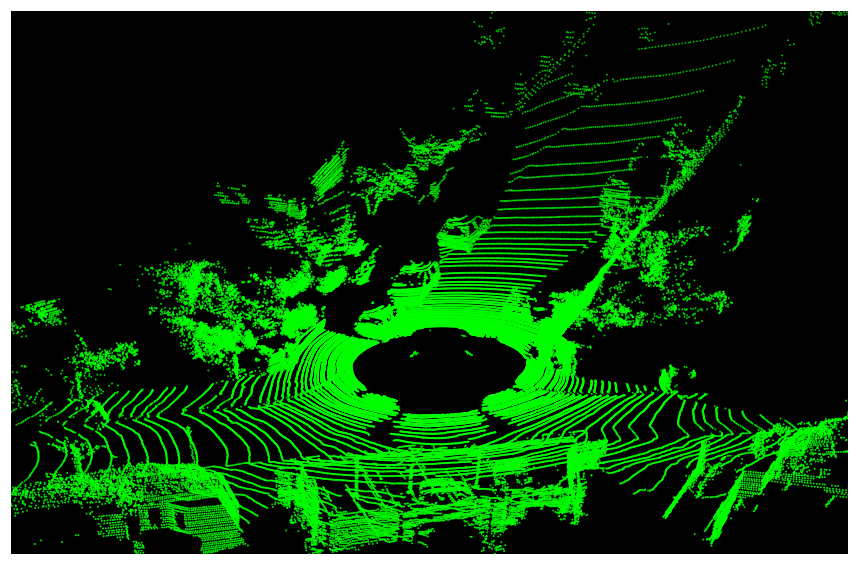

In [14]:
draw3D(point_cloud,(0,1,0),(60,180))

In [15]:
for detection in detections_with_distance:
    detection = detection.numpy()
    point_cloud = np.fromfile(lidar_path, dtype=np.float32).reshape(-1, 4)

    box_h = ((detection[3] - detection[1]) / unpad_h) * img_height_orig
    box_w = ((detection[2] - detection[0]) / unpad_w) * img_width_orig
    v_upper = ((detection[1] - pad_y // 2) / unpad_h) * img_height_orig
    u_left = ((detection[0] - pad_x // 2) / unpad_w) * img_width_orig
    v_bottom = v_upper + box_h
    u_right = u_left + box_w
    D_rough = Height_of_camera * fv / (v_bottom - img_height_orig/2)
    if D_rough > 0:
        # remove points that are located behind the camera:
        point_cloud = point_cloud[point_cloud[:, 0] > (D_rough - 3), :]
        # remove points that are located too far away from the camera:
        point_cloud = point_cloud[point_cloud[:, 0] < min(80, D_rough + 3), :]
        point_cloud = point_cloud[point_cloud[:,2] > -1.5,:]
        point_cloud = point_cloud[point_cloud[:,2] < -0.5,:]
        
        ########################################################################
        # point_cloud               n x 4   original xyzr value before cali in velo coordinate
        # point_cloud_xyz           n x 3   xyz value before cali in velo coordinate
        # point_cloud_xyz_hom       n x 4   xyz1 in velo coordinate
        # point_cloud_xyz_camera    n x 4   xyz1 in camera coordinate
        # point_cloud_camera        n x 4   xyzr in camera coordinate
        # img_points_hom            n x 3   uv_
        # img_points                n x 2   UV
        ########################################################################
        
        R0_rect = np.eye(4)
        R0_rect[0:3, 0:3] = calib["R0_rect"] # 3x3 -> 4x4 up left corner
        Tr_velo_to_cam = np.eye(4)
        Tr_velo_to_cam[0:3, :] = calib["Tr_velo_to_cam"] # 3x4 -> 4x4 up left corner

        # point_cloud_xyz = point_cloud[:, 0:3] # num_point x 3 (x,y,z,reflectance) reflectance don't need
        point_cloud_xyz_hom = np.ones((point_cloud.shape[0], 4))
        point_cloud_xyz_hom[:, 0:3] = point_cloud[:, 0:3] # (point_cloud_xyz_hom has shape (num_points, 4))
        # the 4th column are all 1

        # project the points onto the image plane (homogeneous coords):
        # (U,V,_) = P2 * R0_rect * Tr_velo_to_cam * point_cloud_xyz_hom
        # normalize: (U,V,1)
        img_points_hom = np.dot(P2, np.dot(R0_rect, np.dot(Tr_velo_to_cam, point_cloud_xyz_hom.T))).T # (point_cloud_xyz_hom.T has shape (4, num_points))
        img_points = np.zeros((img_points_hom.shape[0], 2))
        img_points[:, 0] = img_points_hom[:, 0]/img_points_hom[:, 2]
        img_points[:, 1] = img_points_hom[:, 1]/img_points_hom[:, 2]

        # transform the points into (rectified) camera coordinates:
        # normalize: (x,y,z,1)
#         point_cloud_xyz_camera_hom = np.dot(R0_rect, np.dot(Tr_velo_to_cam, point_cloud_xyz_hom.T)).T # (point_cloud_xyz_hom.T has shape (4, num_points))
#         point_cloud_xyz_camera = np.zeros((point_cloud_xyz_camera_hom.shape[0], 3))
#         point_cloud_xyz_camera[:, 0] = point_cloud_xyz_camera_hom[:, 0]/point_cloud_xyz_camera_hom[:, 3]
#         point_cloud_xyz_camera[:, 1] = point_cloud_xyz_camera_hom[:, 1]/point_cloud_xyz_camera_hom[:, 3]
#         point_cloud_xyz_camera[:, 2] = point_cloud_xyz_camera_hom[:, 2]/point_cloud_xyz_camera_hom[:, 3]

#         point_cloud_camera = point_cloud
#         point_cloud_camera[:, 0:3] = point_cloud_xyz_camera # reserve reflection

        row_mask = np.logical_and(
                        np.logical_and(img_points[:, 0] >= u_left,
                                       img_points[:, 0] <= u_right),
                        np.logical_and(img_points[:, 1] >= v_upper,
                                       img_points[:, 1] <= v_bottom))

        # filter out point are not in frustum area
#         frustum_point_cloud = point_cloud[row_mask, :]
#         frustum_point_cloud_xyz_camera = point_cloud_xyz_camera[row_mask, :]


In [16]:
point_cloud

array([[ 8.35 , 13.463, -0.501,  0.27 ],
       [ 8.596, 11.96 , -0.536,  0.25 ],
       [ 8.627, 12.164, -0.545,  0.25 ],
       ...,
       [ 4.138,  1.912, -1.39 ,  0.39 ],
       [ 4.123,  1.913, -1.386,  0.39 ],
       [ 4.134,  1.986, -1.442,  0.06 ]], dtype=float32)

In [17]:
point_cloud_mask = point_cloud[row_mask,:]

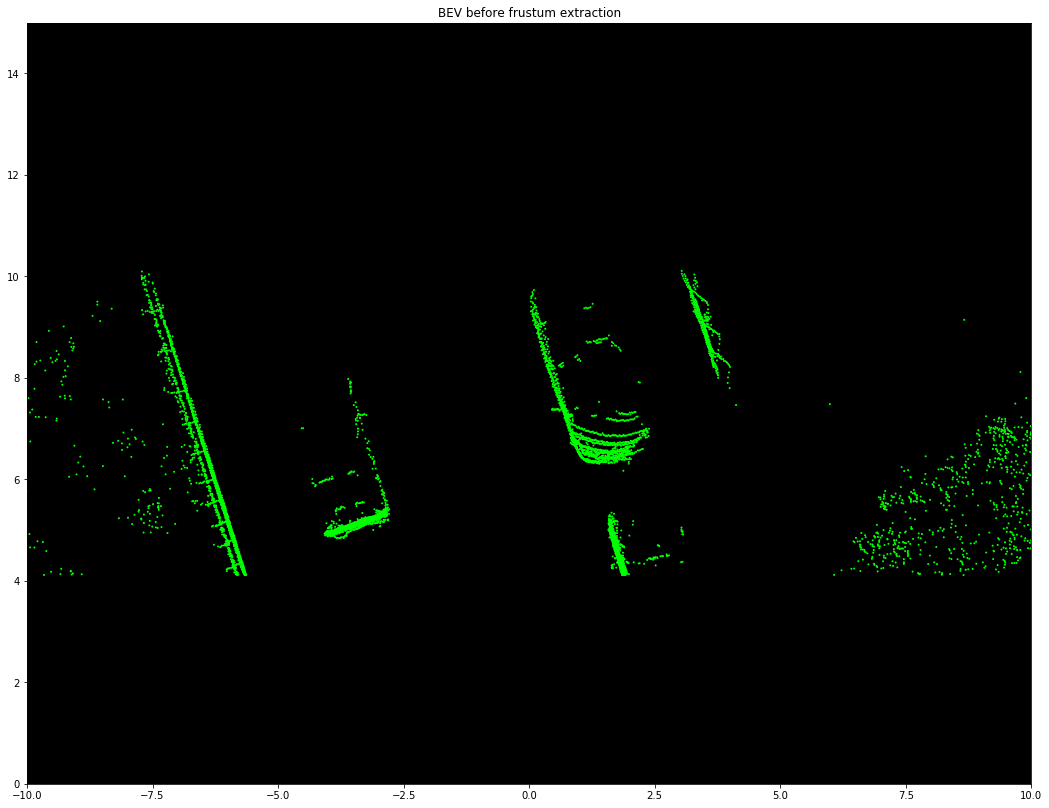

D_rough 7.112372944615878


In [18]:
drawBEV(point_cloud,(0,1,0))
print('D_rough',D_rough)

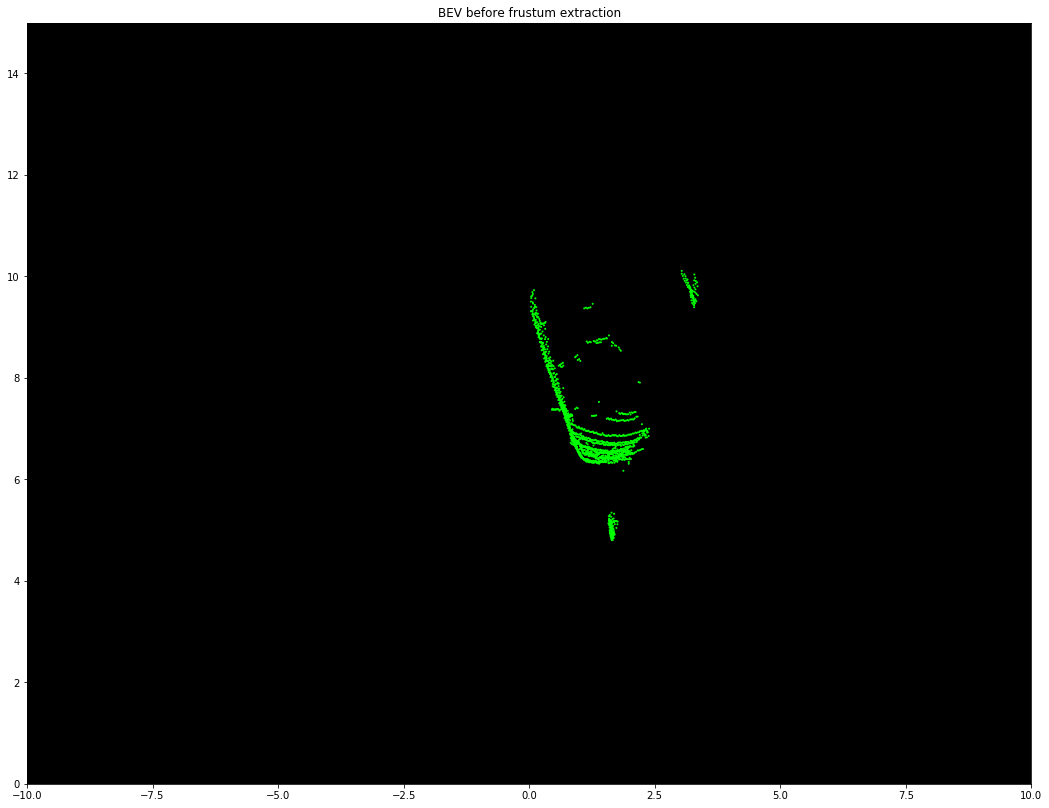

<Figure size 432x288 with 0 Axes>

In [19]:
drawBEV(point_cloud_mask,(0,1,0))
plt.savefig('BEV_after_frustum_extraction',format='pdf',dpi=300)

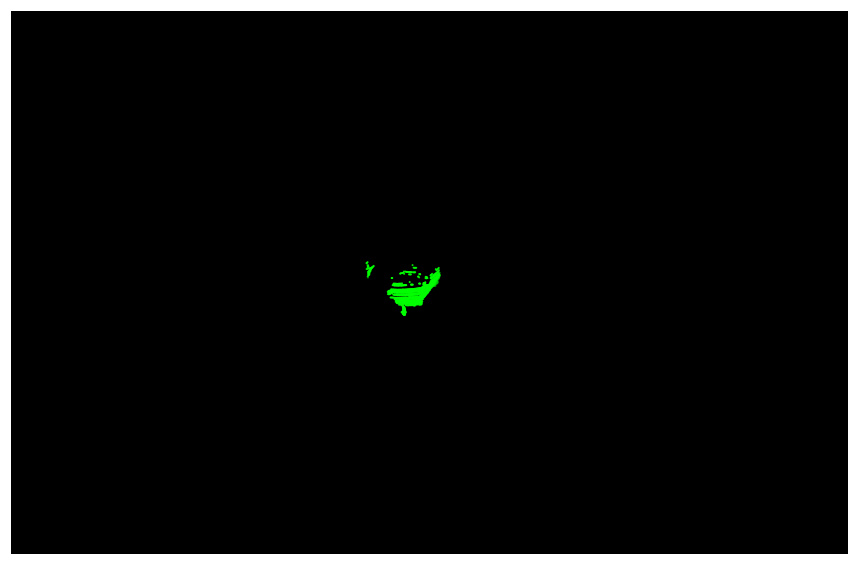

In [20]:
draw3D(point_cloud_mask)

In [24]:
from sklearn import linear_model

ransac = linear_model.RANSACRegressor(max_trials=500,)
ransac.fit(point_cloud_mask[:,1].reshape(-1,1),point_cloud_mask[:,0].reshape(-1,1))

RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
        loss='absolute_loss', max_skips=inf, max_trials=500,
        min_samples=None, random_state=None, residual_threshold=None,
        stop_n_inliers=inf, stop_probability=0.99, stop_score=inf)

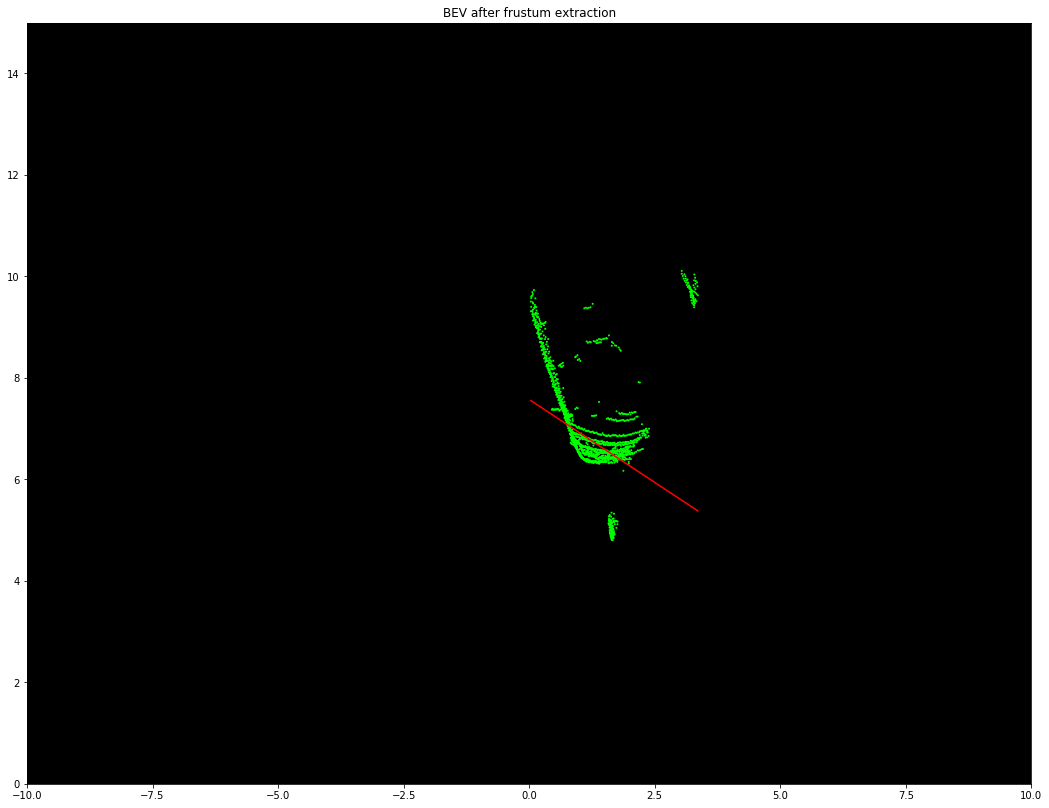

In [25]:
f4 = plt.figure(figsize=(18, 14))
ax4 = f4.add_subplot(111)
ax4.scatter(point_cloud_mask[:,1],point_cloud_mask[:,0],
            s=1, c=[(0,1,0)]*len(point_cloud_mask))
left_y = point_cloud[row_mask,1].min()
right_y = point_cloud[row_mask,1].max()
left_x = ransac.predict([[left_y,]])[0][0]
right_x = ransac.predict([[right_y,]])[0][0]

ax4.plot([left_y,right_y],[left_x,right_x],'k-', color = 'r')
ax4.set_title('BEV after frustum extraction')
ax4.set_ylim(0,15)
ax4.set_xlim(-10,10)
ax4.set_facecolor((0,0,0))


NameError: name 'point_after_mask' is not defined

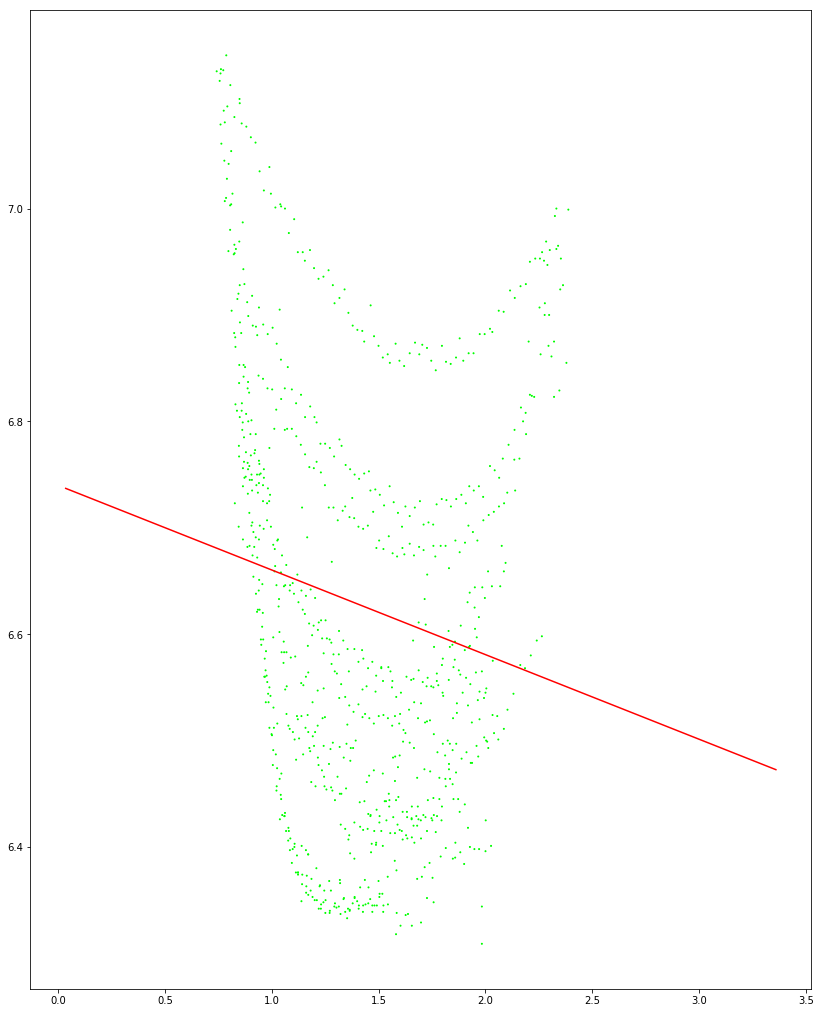

In [23]:
from itertools import compress
left_y = point_cloud_mask[:,1].min()
right_y = point_cloud_mask[:,1].max()

inlier_index =  list(compress(range(len(ransac.inlier_mask_)), ransac.inlier_mask_))

f5 = plt.figure(figsize=(14, 18))
ax5 = f5.add_subplot(111)
ax5.scatter(point_cloud_mask[inlier_index,1],point_cloud_mask[inlier_index,0],
            s=1,c=[(0,1,0)]*len(point_cloud_mask[inlier_index,0]))

left_y = point_cloud[row_mask,1].min()
right_y = point_cloud[row_mask,1].max()
left_x = ransac.predict([[left_y,]])[0][0]
right_x = ransac.predict([[right_y,]])[0][0]

ax5.plot([left_y,right_y],[left_x,right_x],'k-', color = 'r')

outlier_index =  list(compress(range(len(ransac.inlier_mask_)), [not i for i in ransac.inlier_mask_]))
ax5.scatter(point_cloud_mask[outlier_index,1],point_cloud_mask[outlier_index,0],
            s=1,c=[(1,1,0)]*len(point_after_mask[outlier_index,0]))

ransac.fit(point_after_mask[outlier_index,1].reshape(-1,1),point_after_mask[outlier_index,0].reshape(-1,1))
left_x = ransac.predict([[left_y,]])[0][0]
right_x = ransac.predict([[right_y,]])[0][0]
ax5.plot([left_y,right_y],[left_x,right_x],'k-', color = 'r')

ax5.set_title('BEV after frustum extraction')
ax5.set_xlim(0,15)
ax5.set_ylim(-10,10)
ax5.set_facecolor((0,0,0))
